# kykim/albert-kor-base

## def

In [2]:
def generate_data_loader(file_path, tokenizer, args):
    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))
    return data_loader

In [3]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [1]:
import os
import random
import easydict
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
def train(model, args, train_loader, valid_loader, patience=10):
    experiment_name = f"model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}"
    writer = SummaryWriter(f'hai_kaggle/{experiment_name}')

    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    best_val_accuracy = 0.0
    best_train_accuracy = 0.0
    epochs_without_improvement = 0

    train_accuracies = []
    val_accuracies = []

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            model.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0]
            train_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            writer.add_scalar('training loss',
                            loss.item(),
                            epoch * len(train_loader) + step)

        avg_train_loss = np.mean(train_loss)
        _, _, avg_train_accuracy = predict(model, args, train_loader)
        _, _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)

        writer.add_scalar('training accuracy',
                        avg_train_accuracy,
                        epoch)
        writer.add_scalar('validation accuracy',
                        avg_val_accuracy,
                        epoch)

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_train_accuracy = avg_train_accuracy
            epochs_without_improvement = 0
            save_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}"
            save(model, save_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"[Early Stopping]{patience} epoch에서 중단.[Early Stopping]")
            break

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    model_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/model.pth"
    model.load_state_dict(torch.load(model_path))

    print(f"Best Train Accuracy: {best_train_accuracy}, Best Validation Accuracy: {best_val_accuracy}")

    writer.add_hparams({
        'lr': args.lr,
        'eps': args.eps,
        'batch': args.batch,
        'epochs': args.epochs,
        'maxlen': args.maxlen
        }, {
        'best_train_accuracy': best_train_accuracy,
        'best_val_accuracy': best_val_accuracy
        })

    writer.close()
    return model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies

In [5]:
# best_train_accuracy & best_val_accuracy는 모델 경로 때문에 주는 것임!
def test(model, tokenizer, test_args, file_path, args, best_train_accuracy, best_val_accuracy):
    if torch.cuda.is_available():
        test_args.device = 'cuda'

    test_dataloader = generate_data_loader(file_path, tokenizer=tokenizer, args=test_args)
    labels, _ = predict(model, test_args, test_dataloader)

    submit_df = pd.DataFrame()
    submit_df["idx"] = range(len(labels))
    submit_df["label"] = labels
    save_path = f"./saved_checkpoints/best_model/model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/submission.csv"
    submit_df.to_csv(save_path, index=False)
    print(f"Submission file saved to {save_path}")

In [6]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_loss = []
    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            if args.mode == 'test':
                outputs = model(b_input_ids, attention_mask=b_input_mask)
                logit = outputs[0]
            else:
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss, logit = outputs[:2]
                eval_loss.append(loss.item())

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        if args.mode != 'test':
            accuracy = flat_accuracy(logit, label)
            eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)

    if args.mode == 'test':
        return predict_labels, None

    avg_eval_loss = np.mean(eval_loss)
    avg_eval_accuracy = np.mean(eval_accuracy)

    return predict_labels, avg_eval_loss, avg_eval_accuracy

In [7]:
from transformers import BertTokenizerFast, AlbertModel

In [8]:
def train_valid(args):
    if torch.cuda.is_available():
        args.device = 'cuda'
    else:
        args.device = 'cpu'

    tokenizer = BertTokenizerFast.from_pretrained(args.model_ckpt, do_lower_case=False)
    model = AlbertForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
    model.to(args.device)
    train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
    validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

    model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies = train(model, args, train_dataloader, validation_dataloader)

    return model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy

## 64/32/8.00E-05/1.00E-08/50 patience = 5

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 199811.42it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 262009.36it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 161160.12it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [09:11<00:00,  5.41it/s]


start predict


2981it [03:29, 14.20it/s]


start predict


16it [00:01, 15.07it/s]


Epoch 0,  Average training loss: 0.2872 , Train accuracy : 0.9336, Validation accuracy : 0.8987


training epoch 1: 100%|█████████████████████| 2981/2981 [09:18<00:00,  5.34it/s]


start predict


2981it [03:29, 14.21it/s]


start predict


16it [00:01, 15.08it/s]


Epoch 1,  Average training loss: 0.1948 , Train accuracy : 0.9508, Validation accuracy : 0.9190


training epoch 2: 100%|█████████████████████| 2981/2981 [09:18<00:00,  5.34it/s]


start predict


2981it [03:29, 14.22it/s]


start predict


16it [00:01, 15.07it/s]


Epoch 2,  Average training loss: 0.1510 , Train accuracy : 0.9653, Validation accuracy : 0.9229


training epoch 3: 100%|█████████████████████| 2981/2981 [09:18<00:00,  5.33it/s]


start predict


2981it [03:30, 14.19it/s]


start predict


16it [00:01, 15.05it/s]


Epoch 3,  Average training loss: 0.1166 , Train accuracy : 0.9751, Validation accuracy : 0.9142


training epoch 4: 100%|█████████████████████| 2981/2981 [09:19<00:00,  5.33it/s]


start predict


2981it [03:29, 14.21it/s]


start predict


16it [00:01, 15.07it/s]


Epoch 4,  Average training loss: 0.0887 , Train accuracy : 0.9799, Validation accuracy : 0.9073


training epoch 5: 100%|█████████████████████| 2981/2981 [09:19<00:00,  5.33it/s]


start predict


2981it [03:29, 14.21it/s]


start predict


16it [00:01, 15.05it/s]


Epoch 5,  Average training loss: 0.0692 , Train accuracy : 0.9874, Validation accuracy : 0.9075


training epoch 6: 100%|█████████████████████| 2981/2981 [09:18<00:00,  5.33it/s]


start predict


2981it [03:30, 14.18it/s]


start predict


16it [00:01, 15.07it/s]


Epoch 6,  Average training loss: 0.0552 , Train accuracy : 0.9907, Validation accuracy : 0.9074


training epoch 7: 100%|█████████████████████| 2981/2981 [09:19<00:00,  5.33it/s]


start predict


2981it [03:28, 14.30it/s]


start predict


16it [00:01, 15.17it/s]


Epoch 7,  Average training loss: 0.0458 , Train accuracy : 0.9923, Validation accuracy : 0.9122
[Early Stopping]5 epoch에서 중단.[Early Stopping]


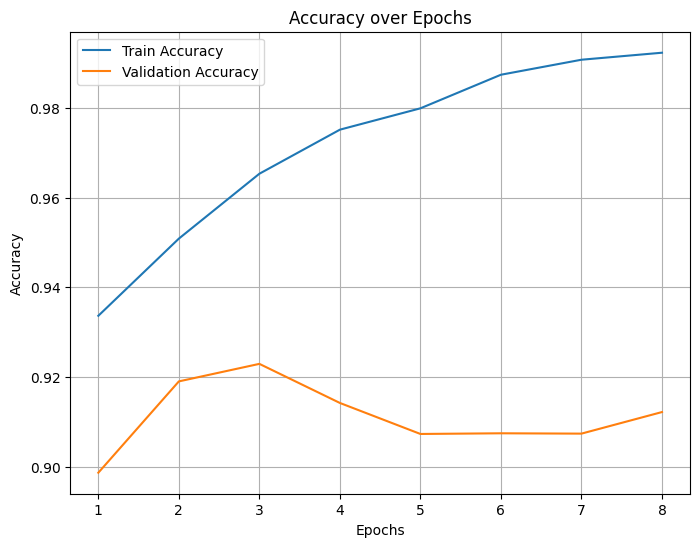

Best Train Accuracy: 0.9653052666890305, Best Validation Accuracy: 0.9229266826923077


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 250800.87it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 165571.59it/s]


start predict


10it [00:00, 15.39it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_kykim_albert-kor-base_lr_8e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9653052666890305_ValAcc_0.9229266826923077/submission.csv


In [9]:
# patience = 5
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 8e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "kykim/albert-kor-base",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

## 64/32/8.00E-05/1.00E-08/50 patience = 10

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 233991.96it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 264866.16it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 154480.20it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [09:09<00:00,  5.42it/s]


start predict


2981it [03:29, 14.25it/s]


start predict


16it [00:01, 15.09it/s]


Epoch 0,  Average training loss: 0.2910 , Train accuracy : 0.9315, Validation accuracy : 0.9005


training epoch 1: 100%|█████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:32, 14.04it/s]


start predict


16it [00:01, 14.86it/s]


Epoch 1,  Average training loss: 0.1960 , Train accuracy : 0.9490, Validation accuracy : 0.9102


training epoch 2: 100%|█████████████████████| 2981/2981 [09:27<00:00,  5.26it/s]


start predict


2981it [03:32, 14.03it/s]


start predict


16it [00:01, 14.88it/s]


Epoch 2,  Average training loss: 0.1527 , Train accuracy : 0.9647, Validation accuracy : 0.9112


training epoch 3: 100%|█████████████████████| 2981/2981 [09:27<00:00,  5.25it/s]


start predict


2981it [03:32, 14.01it/s]


start predict


16it [00:01, 14.89it/s]


Epoch 3,  Average training loss: 0.1167 , Train accuracy : 0.9764, Validation accuracy : 0.9085


training epoch 4: 100%|█████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:32, 14.05it/s]


start predict


16it [00:01, 14.89it/s]


Epoch 4,  Average training loss: 0.0882 , Train accuracy : 0.9824, Validation accuracy : 0.9141


training epoch 5: 100%|█████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:31, 14.11it/s]


start predict


16it [00:01, 14.98it/s]


Epoch 5,  Average training loss: 0.0682 , Train accuracy : 0.9870, Validation accuracy : 0.9151


training epoch 6: 100%|█████████████████████| 2981/2981 [09:24<00:00,  5.28it/s]


start predict


2981it [03:30, 14.14it/s]


start predict


16it [00:01, 15.00it/s]


Epoch 6,  Average training loss: 0.0563 , Train accuracy : 0.9909, Validation accuracy : 0.9084


training epoch 7: 100%|█████████████████████| 2981/2981 [09:25<00:00,  5.28it/s]


start predict


2981it [03:32, 14.06it/s]


start predict


16it [00:01, 14.92it/s]


Epoch 7,  Average training loss: 0.0466 , Train accuracy : 0.9896, Validation accuracy : 0.9093


training epoch 8: 100%|█████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:32, 14.06it/s]


start predict


16it [00:01, 14.88it/s]


Epoch 8,  Average training loss: 0.0404 , Train accuracy : 0.9922, Validation accuracy : 0.9015


training epoch 9: 100%|█████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:31, 14.07it/s]


start predict


16it [00:01, 14.92it/s]


Epoch 9,  Average training loss: 0.0353 , Train accuracy : 0.9942, Validation accuracy : 0.9170


training epoch 10: 100%|████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:31, 14.07it/s]


start predict


16it [00:01, 14.89it/s]


Epoch 10,  Average training loss: 0.0304 , Train accuracy : 0.9946, Validation accuracy : 0.9102


training epoch 11: 100%|████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:31, 14.10it/s]


start predict


16it [00:01, 14.97it/s]


Epoch 11,  Average training loss: 0.0271 , Train accuracy : 0.9948, Validation accuracy : 0.9180


training epoch 12: 100%|████████████████████| 2981/2981 [09:25<00:00,  5.27it/s]


start predict


2981it [03:31, 14.11it/s]


start predict


16it [00:01, 14.94it/s]


Epoch 12,  Average training loss: 0.0249 , Train accuracy : 0.9947, Validation accuracy : 0.9102


training epoch 13: 100%|████████████████████| 2981/2981 [09:24<00:00,  5.28it/s]


start predict


2981it [03:30, 14.14it/s]


start predict


16it [00:01, 14.99it/s]


Epoch 13,  Average training loss: 0.0220 , Train accuracy : 0.9952, Validation accuracy : 0.9074


training epoch 14: 100%|████████████████████| 2981/2981 [09:23<00:00,  5.29it/s]


start predict


2981it [03:30, 14.14it/s]


start predict


16it [00:01, 15.01it/s]


Epoch 14,  Average training loss: 0.0199 , Train accuracy : 0.9935, Validation accuracy : 0.9170


training epoch 15: 100%|████████████████████| 2981/2981 [09:21<00:00,  5.31it/s]


start predict


2981it [03:30, 14.19it/s]


start predict


16it [00:01, 15.04it/s]


Epoch 15,  Average training loss: 0.0179 , Train accuracy : 0.9971, Validation accuracy : 0.9170


training epoch 16: 100%|████████████████████| 2981/2981 [09:22<00:00,  5.30it/s]


start predict


2981it [03:32, 14.05it/s]


start predict


16it [00:01, 14.87it/s]


Epoch 16,  Average training loss: 0.0163 , Train accuracy : 0.9970, Validation accuracy : 0.9199


training epoch 17: 100%|████████████████████| 2981/2981 [09:28<00:00,  5.25it/s]


start predict


2981it [03:32, 14.06it/s]


start predict


16it [00:01, 14.93it/s]


Epoch 17,  Average training loss: 0.0154 , Train accuracy : 0.9976, Validation accuracy : 0.9024


training epoch 18: 100%|████████████████████| 2981/2981 [09:24<00:00,  5.28it/s]


start predict


2981it [03:30, 14.15it/s]


start predict


16it [00:01, 14.97it/s]


Epoch 18,  Average training loss: 0.0152 , Train accuracy : 0.9979, Validation accuracy : 0.9015


training epoch 19: 100%|████████████████████| 2981/2981 [09:25<00:00,  5.27it/s]


start predict


2981it [03:30, 14.13it/s]


start predict


16it [00:01, 15.00it/s]


Epoch 19,  Average training loss: 0.0128 , Train accuracy : 0.9975, Validation accuracy : 0.9121


training epoch 20: 100%|████████████████████| 2981/2981 [09:24<00:00,  5.28it/s]


start predict


2981it [03:30, 14.18it/s]


start predict


16it [00:01, 15.03it/s]


Epoch 20,  Average training loss: 0.0128 , Train accuracy : 0.9979, Validation accuracy : 0.9035


training epoch 21: 100%|████████████████████| 2981/2981 [09:25<00:00,  5.27it/s]


start predict


2981it [03:32, 14.01it/s]


start predict


16it [00:01, 14.85it/s]


Epoch 21,  Average training loss: 0.0118 , Train accuracy : 0.9981, Validation accuracy : 0.9141


training epoch 22: 100%|████████████████████| 2981/2981 [09:29<00:00,  5.24it/s]


start predict


2981it [03:32, 14.01it/s]


start predict


16it [00:01, 14.83it/s]


Epoch 22,  Average training loss: 0.0107 , Train accuracy : 0.9982, Validation accuracy : 0.9160


training epoch 23: 100%|████████████████████| 2981/2981 [09:26<00:00,  5.26it/s]


start predict


2981it [03:28, 14.30it/s]


start predict


16it [00:01, 15.20it/s]


Epoch 23,  Average training loss: 0.0091 , Train accuracy : 0.9983, Validation accuracy : 0.9150


training epoch 24: 100%|████████████████████| 2981/2981 [09:14<00:00,  5.38it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.26it/s]


Epoch 24,  Average training loss: 0.0084 , Train accuracy : 0.9987, Validation accuracy : 0.9229


training epoch 25: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.27it/s]


Epoch 25,  Average training loss: 0.0079 , Train accuracy : 0.9987, Validation accuracy : 0.9189


training epoch 26: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.28it/s]


Epoch 26,  Average training loss: 0.0068 , Train accuracy : 0.9989, Validation accuracy : 0.9229


training epoch 27: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.31it/s]


Epoch 27,  Average training loss: 0.0066 , Train accuracy : 0.9988, Validation accuracy : 0.9142


training epoch 28: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.29it/s]


Epoch 28,  Average training loss: 0.0062 , Train accuracy : 0.9987, Validation accuracy : 0.9151


training epoch 29: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.38it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.28it/s]


Epoch 29,  Average training loss: 0.0054 , Train accuracy : 0.9984, Validation accuracy : 0.9094


training epoch 30: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.28it/s]


Epoch 30,  Average training loss: 0.0058 , Train accuracy : 0.9989, Validation accuracy : 0.9112


training epoch 31: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.43it/s]


start predict


16it [00:01, 15.28it/s]


Epoch 31,  Average training loss: 0.0054 , Train accuracy : 0.9990, Validation accuracy : 0.9093


training epoch 32: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.28it/s]


Epoch 32,  Average training loss: 0.0044 , Train accuracy : 0.9991, Validation accuracy : 0.9026


training epoch 33: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.38it/s]


start predict


2981it [03:26, 14.40it/s]


start predict


16it [00:01, 15.24it/s]


Epoch 33,  Average training loss: 0.0042 , Train accuracy : 0.9992, Validation accuracy : 0.9073


training epoch 34: 100%|████████████████████| 2981/2981 [09:13<00:00,  5.38it/s]


start predict


2981it [03:26, 14.42it/s]


start predict


16it [00:01, 15.26it/s]

Epoch 34,  Average training loss: 0.0035 , Train accuracy : 0.9993, Validation accuracy : 0.8949
[Early Stopping]10 epoch에서 중단.[Early Stopping]


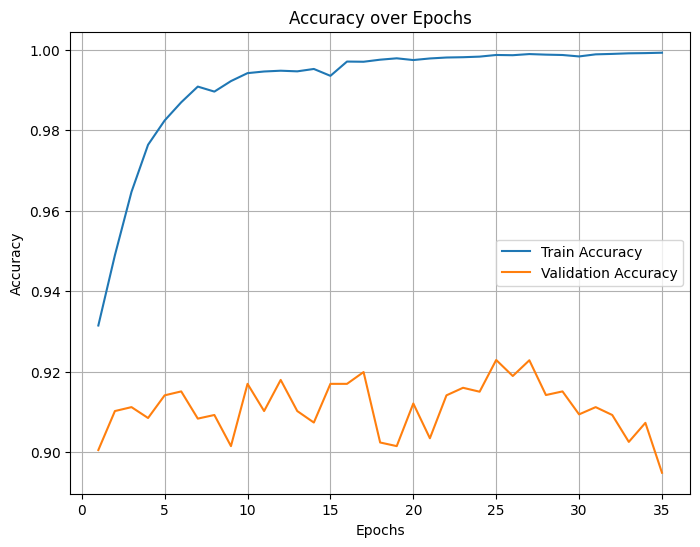

Best Train Accuracy: 0.9987210667561222, Best Validation Accuracy: 0.9229266826923077


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 197802.80it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 145182.99it/s]


start predict


10it [00:00, 15.38it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_kykim_albert-kor-base_lr_8e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9987210667561222_ValAcc_0.9229266826923077/submission.csv


In [13]:
# patience = 10
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 8e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "kykim/albert-kor-base",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

## 64/32/8.00E-04/1.00E-08/50 patience = 5

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 236038.84it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 277471.97it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 160167.10it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [08:50<00:00,  5.62it/s]


start predict


2981it [03:14, 15.35it/s]


start predict


16it [00:00, 16.25it/s]


Epoch 0,  Average training loss: 0.9913 , Train accuracy : 0.5793, Validation accuracy : 0.5600


training epoch 1: 100%|█████████████████████| 2981/2981 [08:48<00:00,  5.64it/s]


start predict


2981it [03:13, 15.39it/s]


start predict


16it [00:00, 16.29it/s]


Epoch 1,  Average training loss: 0.9761 , Train accuracy : 0.5793, Validation accuracy : 0.5600


training epoch 2: 100%|█████████████████████| 2981/2981 [08:48<00:00,  5.64it/s]


start predict


2981it [03:13, 15.40it/s]


start predict


16it [00:00, 16.31it/s]


Epoch 2,  Average training loss: 0.9735 , Train accuracy : 0.5794, Validation accuracy : 0.5753


training epoch 3: 100%|█████████████████████| 2981/2981 [08:48<00:00,  5.64it/s]


start predict


2981it [03:12, 15.48it/s]


start predict


16it [00:00, 16.41it/s]


Epoch 3,  Average training loss: 0.9731 , Train accuracy : 0.5793, Validation accuracy : 0.5562


training epoch 4: 100%|█████████████████████| 2981/2981 [08:46<00:00,  5.67it/s]


start predict


2981it [03:12, 15.50it/s]


start predict


16it [00:00, 16.40it/s]


Epoch 4,  Average training loss: 0.9728 , Train accuracy : 0.5793, Validation accuracy : 0.5600


training epoch 5: 100%|█████████████████████| 2981/2981 [08:45<00:00,  5.68it/s]


start predict


2981it [03:11, 15.53it/s]


start predict


16it [00:00, 16.43it/s]


Epoch 5,  Average training loss: 0.9725 , Train accuracy : 0.5793, Validation accuracy : 0.5485


training epoch 6: 100%|█████████████████████| 2981/2981 [08:45<00:00,  5.68it/s]


start predict


2981it [03:12, 15.51it/s]


start predict


16it [00:00, 16.42it/s]


Epoch 6,  Average training loss: 0.9723 , Train accuracy : 0.5793, Validation accuracy : 0.5677


training epoch 7: 100%|█████████████████████| 2981/2981 [08:45<00:00,  5.67it/s]


start predict


2981it [03:11, 15.55it/s]


start predict


16it [00:00, 16.45it/s]

Epoch 7,  Average training loss: 0.9722 , Train accuracy : 0.5793, Validation accuracy : 0.5562
[Early Stopping]5 epoch에서 중단.[Early Stopping]


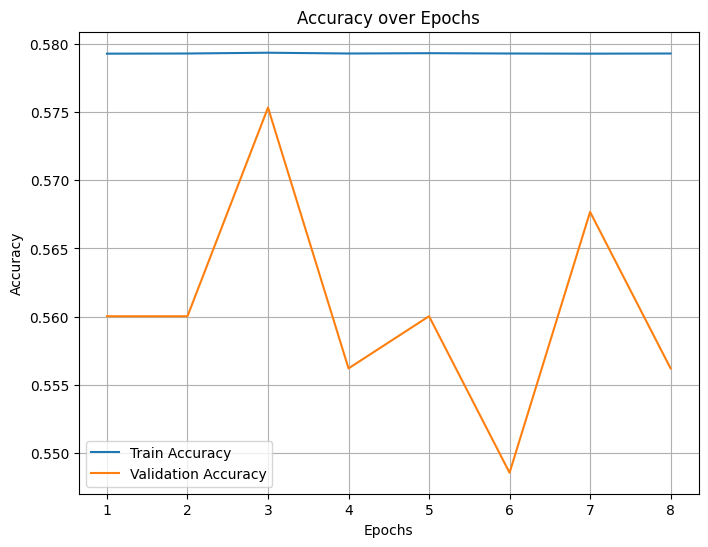

Best Train Accuracy: 0.5793745806776249, Best Validation Accuracy: 0.5753455528846154


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 257718.33it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 163163.95it/s]


start predict


10it [00:00, 16.28it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_kykim_albert-kor-base_lr_0.0008_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.5793745806776249_ValAcc_0.5753455528846154/submission.csv


In [10]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 8e-4,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "kykim/albert-kor-base",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

## 64/32/8.00E-06/1.00E-08/50 patience = 10

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 236561.75it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 270394.08it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 160016.38it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [09:08<00:00,  5.44it/s]


start predict


2981it [03:26, 14.45it/s]


start predict


16it [00:01, 15.31it/s]


Epoch 0,  Average training loss: 0.3256 , Train accuracy : 0.9222, Validation accuracy : 0.8996


training epoch 1: 100%|█████████████████████| 2981/2981 [09:09<00:00,  5.43it/s]


start predict


2981it [03:26, 14.45it/s]


start predict


16it [00:01, 15.31it/s]


Epoch 1,  Average training loss: 0.2017 , Train accuracy : 0.9445, Validation accuracy : 0.9150


training epoch 2: 100%|█████████████████████| 2981/2981 [09:09<00:00,  5.43it/s]


start predict


2981it [03:26, 14.45it/s]


start predict


16it [00:01, 15.29it/s]


Epoch 2,  Average training loss: 0.1626 , Train accuracy : 0.9564, Validation accuracy : 0.9239


training epoch 3: 100%|█████████████████████| 2981/2981 [09:08<00:00,  5.43it/s]


start predict


2981it [03:26, 14.46it/s]


start predict


16it [00:01, 15.32it/s]


Epoch 3,  Average training loss: 0.1290 , Train accuracy : 0.9694, Validation accuracy : 0.9142


training epoch 4: 100%|█████████████████████| 2981/2981 [09:08<00:00,  5.43it/s]


start predict


2981it [03:26, 14.45it/s]


start predict


16it [00:01, 15.32it/s]


Epoch 4,  Average training loss: 0.0977 , Train accuracy : 0.9775, Validation accuracy : 0.9152


training epoch 5: 100%|█████████████████████| 2981/2981 [09:08<00:00,  5.43it/s]


start predict


2981it [03:26, 14.46it/s]


start predict


16it [00:01, 15.32it/s]


Epoch 5,  Average training loss: 0.0698 , Train accuracy : 0.9866, Validation accuracy : 0.9055


training epoch 6: 100%|█████████████████████| 2981/2981 [09:08<00:00,  5.44it/s]


start predict


2981it [03:25, 14.47it/s]


start predict


16it [00:01, 15.33it/s]


Epoch 6,  Average training loss: 0.0489 , Train accuracy : 0.9917, Validation accuracy : 0.9112


training epoch 7: 100%|█████████████████████| 2981/2981 [09:07<00:00,  5.44it/s]


start predict


2981it [03:26, 14.47it/s]


start predict


16it [00:01, 15.33it/s]


Epoch 7,  Average training loss: 0.0347 , Train accuracy : 0.9936, Validation accuracy : 0.9083


training epoch 8: 100%|█████████████████████| 2981/2981 [09:08<00:00,  5.44it/s]


start predict


2981it [03:25, 14.48it/s]


start predict


16it [00:01, 15.32it/s]


Epoch 8,  Average training loss: 0.0264 , Train accuracy : 0.9960, Validation accuracy : 0.8967


training epoch 9: 100%|█████████████████████| 2981/2981 [09:07<00:00,  5.44it/s]


start predict


2981it [03:26, 14.47it/s]


start predict


16it [00:01, 15.31it/s]


Epoch 9,  Average training loss: 0.0201 , Train accuracy : 0.9969, Validation accuracy : 0.9121


training epoch 10: 100%|████████████████████| 2981/2981 [09:09<00:00,  5.42it/s]


start predict


2981it [03:26, 14.41it/s]


start predict


16it [00:01, 15.28it/s]


Epoch 10,  Average training loss: 0.0159 , Train accuracy : 0.9968, Validation accuracy : 0.9131


training epoch 11: 100%|████████████████████| 2981/2981 [09:11<00:00,  5.41it/s]


start predict


2981it [03:27, 14.38it/s]


start predict


16it [00:01, 15.21it/s]


Epoch 11,  Average training loss: 0.0161 , Train accuracy : 0.9976, Validation accuracy : 0.9219


training epoch 12: 100%|████████████████████| 2981/2981 [09:11<00:00,  5.40it/s]


start predict


2981it [03:27, 14.37it/s]


start predict


16it [00:01, 15.23it/s]

Epoch 12,  Average training loss: 0.0126 , Train accuracy : 0.9977, Validation accuracy : 0.9122
[Early Stopping]10 epoch에서 중단.[Early Stopping]


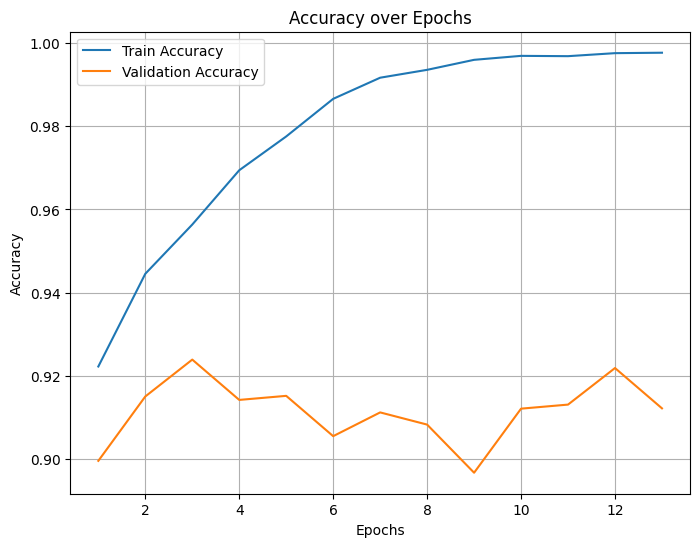

Best Train Accuracy: 0.9563684585709493, Best Validation Accuracy: 0.9239032451923077


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 246561.58it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 165895.89it/s]


start predict


10it [00:00, 15.21it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_kykim_albert-kor-base_lr_8e-06_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9563684585709493_ValAcc_0.9239032451923077/submission.csv


In [14]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 8e-6,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "kykim/albert-kor-base",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

## 64/128/8.00E-06/1.00E-08/50 patience = 10

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 193975.32it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 257610.01it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 43359.69it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [31:19<00:00,  1.59it/s]


start predict


2981it [13:22,  3.71it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 0,  Average training loss: 0.3288 , Train accuracy : 0.9190, Validation accuracy : 0.8947


training epoch 1: 100%|█████████████████████| 2981/2981 [31:26<00:00,  1.58it/s]


start predict


2981it [13:24,  3.70it/s]


start predict


16it [00:04,  3.90it/s]


Epoch 1,  Average training loss: 0.2060 , Train accuracy : 0.9431, Validation accuracy : 0.9180


training epoch 2: 100%|█████████████████████| 2981/2981 [31:29<00:00,  1.58it/s]


start predict


2981it [13:23,  3.71it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 2,  Average training loss: 0.1658 , Train accuracy : 0.9566, Validation accuracy : 0.9180


training epoch 3: 100%|█████████████████████| 2981/2981 [31:25<00:00,  1.58it/s]


start predict


2981it [13:23,  3.71it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 3,  Average training loss: 0.1313 , Train accuracy : 0.9694, Validation accuracy : 0.9132


training epoch 4: 100%|█████████████████████| 2981/2981 [31:29<00:00,  1.58it/s]


start predict


2981it [13:24,  3.70it/s]


start predict


16it [00:04,  3.90it/s]


Epoch 4,  Average training loss: 0.1006 , Train accuracy : 0.9770, Validation accuracy : 0.9073


training epoch 5: 100%|█████████████████████| 2981/2981 [31:31<00:00,  1.58it/s]


start predict


2981it [13:26,  3.70it/s]


start predict


16it [00:04,  3.90it/s]


Epoch 5,  Average training loss: 0.0737 , Train accuracy : 0.9855, Validation accuracy : 0.9026


training epoch 6: 100%|█████████████████████| 2981/2981 [31:32<00:00,  1.58it/s]


start predict


2981it [13:25,  3.70it/s]


start predict


16it [00:04,  3.90it/s]


Epoch 6,  Average training loss: 0.0537 , Train accuracy : 0.9885, Validation accuracy : 0.9103


training epoch 7: 100%|█████████████████████| 2981/2981 [31:25<00:00,  1.58it/s]


start predict


2981it [13:23,  3.71it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 7,  Average training loss: 0.0413 , Train accuracy : 0.9927, Validation accuracy : 0.9014


training epoch 8: 100%|█████████████████████| 2981/2981 [31:23<00:00,  1.58it/s]


start predict


2981it [13:23,  3.71it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 8,  Average training loss: 0.0328 , Train accuracy : 0.9923, Validation accuracy : 0.9074


training epoch 9: 100%|█████████████████████| 2981/2981 [31:22<00:00,  1.58it/s]


start predict


2981it [13:22,  3.71it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 9,  Average training loss: 0.0269 , Train accuracy : 0.9960, Validation accuracy : 0.9092


training epoch 10: 100%|████████████████████| 2981/2981 [31:22<00:00,  1.58it/s]


start predict


2981it [13:21,  3.72it/s]


start predict


16it [00:04,  3.91it/s]


Epoch 10,  Average training loss: 0.0228 , Train accuracy : 0.9957, Validation accuracy : 0.8985


training epoch 11: 100%|████████████████████| 2981/2981 [31:22<00:00,  1.58it/s]


start predict


2981it [13:22,  3.72it/s]


start predict


16it [00:04,  3.91it/s]

Epoch 11,  Average training loss: 0.0204 , Train accuracy : 0.9971, Validation accuracy : 0.9062
[Early Stopping]10 epoch에서 중단.[Early Stopping]


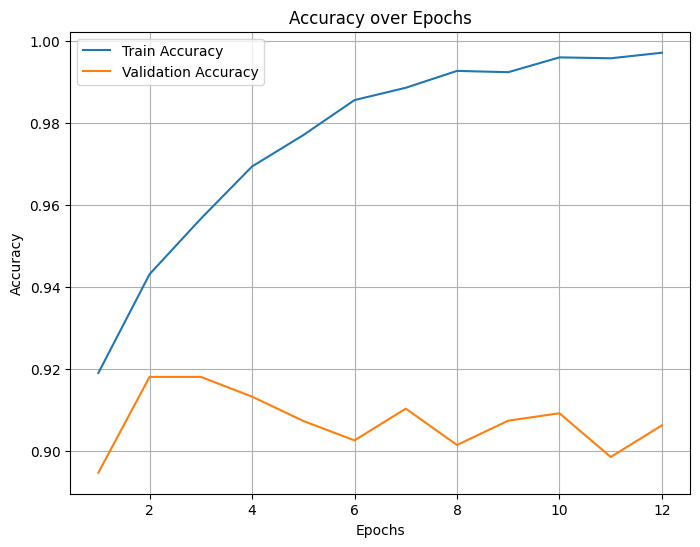

Best Train Accuracy: 0.9430874706474337, Best Validation Accuracy: 0.9180438701923077


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 255114.10it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 46336.09it/s]


start predict


10it [00:02,  3.85it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_kykim_albert-kor-base_lr_8e-06_batch_64_epochs_50_maxlen_128_eps_1e-08_TrainAcc_0.9430874706474337_ValAcc_0.9180438701923077/submission.csv


In [15]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 128,
    "lr" : 8e-6,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "kykim/albert-kor-base",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 128,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)